# Tesseract OCR — Evaluation & Debug Notebook  
**Author:** Manel

## Purpose
Evaluate Tesseract OCR on document pages (PDF → images) with:
- Visual inspection (original + preprocessed)
- OCR text preview
- Word-level bounding boxes and confidence
- Quick sweeps over preprocessing + `psm` layouts


#### Imports

In [1]:
import os
import fitz
import pytesseract
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from pytesseract import Output
from pathlib import Path
import numpy as np
from PIL import Image, ImageOps, ImageEnhance

#### Paths

In [15]:
BASE_DIR = Path.cwd()  # ...\DocumentAgent\Notebooks
DATA_DIR = BASE_DIR.parent / "data" / "images"

#### Display Helpers

In [16]:
def show(img, title=None, figsize=(10, 12)):
    if isinstance(img, (str, Path)):
        img = Image.open(img)
    plt.figure(figsize=figsize)
    cmap = "gray" if img.mode in ["L", "1"] else None
    plt.imshow(img, cmap=cmap)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

def crop(img, x1, y1, x2, y2):
    if isinstance(img, (str, Path)):
        img = Image.open(img)
    return img.crop((x1, y1, x2, y2))

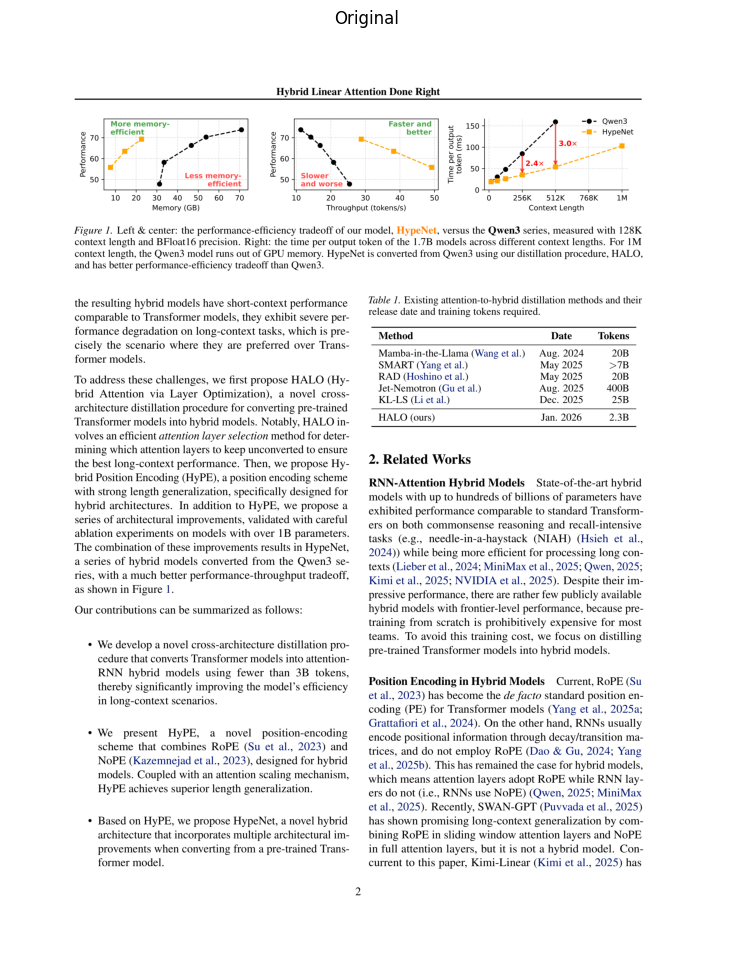

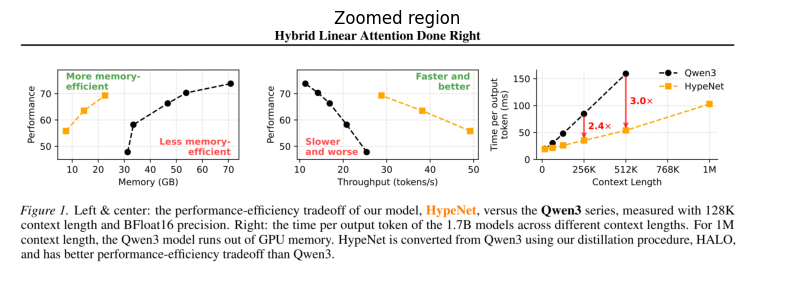

In [19]:
# Example usage
DEFAULT_IMAGE = DATA_DIR / "page_2.png"
show(DEFAULT_IMAGE, "Original")
show(crop(DEFAULT_IMAGE, 200, 200, 2400, 900), "Zoomed region")

#### Preprocessing


OCR quality is highly sensitive to image characteristics.  
These preprocessing steps help Tesseract “see” text more clearly.

-  **Scaling (`scale`)**
    - Enlarges small text → more pixels per character
    - Improves character shape recognition (especially scans & PDFs)

-  **Grayscale (`to_gray`)**
    - Removes color noise
    - Lets OCR focus only on text intensity, not color

-  **Contrast (`contrast`)**
    - Makes text stand out from background
    - Helpful for faded scans or low-quality PDFs

-  **Sharpness (`sharpness`)**
   - Enhances edges of characters
   - Improves separation between letters (e.g. `rn` vs `m`)

-  **Thresholding (`threshold`)**
   - Converts image to pure black & white
   - Reduces background noise and shadows
    - Often boosts OCR confidence on clean documents

- **Invert (`invert`)**
    - Useful for dark-background / white-text documents
   - Matches Tesseract’s expectation: dark text on light background


In [20]:
def preprocess(
    image,
    scale=1.5,
    to_gray=True,
    contrast=1.0,
    sharpness=1.0,
    threshold=None,
    invert=False,
):
    if isinstance(image, (str, Path)):
        image = Image.open(image)

    img = image

    # Scale up )
    if scale != 1.0:
        w, h = img.size
        img = img.resize((int(w * scale), int(h * scale)), Image.Resampling.LANCZOS)

    # Grayscale
    if to_gray:
        img = ImageOps.grayscale(img)

    # Contrast / sharpness 
    if contrast != 1.0:
        img = ImageEnhance.Contrast(img).enhance(contrast)
    if sharpness != 1.0:
        img = ImageEnhance.Sharpness(img).enhance(sharpness)

    # invert
    if invert:
        img = ImageOps.invert(img) if img.mode == "L" else ImageOps.invert(img.convert("L"))

    # Threshold (binarization)
    if threshold is not None:
        img = img.point(lambda p: 255 if p > threshold else 0)

    return img

PRESETS = {
    "raw": dict(scale=1.0, to_gray=False, contrast=1.0, sharpness=1.0, threshold=None, invert=False),
    "gray+scale": dict(scale=1.5, to_gray=True, contrast=1.0, sharpness=1.0, threshold=None, invert=False),
    "thr_170": dict(scale=1.5, to_gray=True, contrast=1.1, sharpness=1.2, threshold=170, invert=False),
    "thr_200": dict(scale=1.5, to_gray=True, contrast=1.2, sharpness=1.2, threshold=200, invert=False),
}

### OCR functions

- **`ocr_text`**
    - Extracts the raw OCR text from an image
    - Uses Tesseract with configurable **OEM** (engine) and **PSM** (page layout mode)

- **`ocr_data`**
    - Returns word-level OCR output as a structured DataFrame
    - Includes text, bounding box coordinates and confidence scores
    - Filters empty tokens and invalid confidence values

-  **`draw_boxes`**
     - Draws bounding boxes around detected words
     - Filters by minimum confidence (`conf_min`)
     - Helps visually inspect:
          - missed text
          - false positives
          - alignment and layout errors

-  **`summarize_conf`**
    - Computes simple confidence statistics:
        - number of detected words
        - mean / median confidence
        - lower and upper confidence percentiles


In [21]:
def ocr_text(img, lang="eng", psm=6, oem=3):
    if isinstance(img, (str, Path)):
        img = Image.open(img)
    config = f"--oem {oem} --psm {psm}"
    return pytesseract.image_to_string(img, lang=lang, config=config)

def ocr_data(img, lang="eng", psm=6, oem=3):
    if isinstance(img, (str, Path)):
        img = Image.open(img)
    config = f"--oem {oem} --psm {psm}"
    df = pytesseract.image_to_data(img, lang=lang, config=config, output_type=Output.DATAFRAME)
    df = df.dropna(subset=["text"])
    df["text"] = df["text"].astype(str).str.strip()
    df["conf"] = pd.to_numeric(df["conf"], errors="coerce")
    df = df.dropna(subset=["conf"])
    df = df[df["text"] != ""]
    return df

def draw_boxes(img, df, conf_min=60, figsize=(12, 14)):
    if isinstance(img, (str, Path)):
        img = Image.open(img)
    img_np = np.array(img.convert("RGB"))

    plt.figure(figsize=figsize)
    plt.imshow(img_np)
    plt.axis("off")
    ax = plt.gca()

    dff = df[df["conf"] >= conf_min].copy()
    for _, r in dff.iterrows():
        x, y, w, h = int(r["left"]), int(r["top"]), int(r["width"]), int(r["height"])
        ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, linewidth=1))
        ax.text(x, y - 2, f'{r["conf"]:.0f}', fontsize=8)

    plt.title(f"Boxes (conf ≥ {conf_min}) | words: {len(dff)}")
    plt.show()

def summarize_conf(df):
    if df.empty:
        return {"words": 0, "conf_mean": None, "conf_median": None, "conf_p10": None, "conf_p90": None}
    return {
        "words": int(len(df)),
        "conf_mean": float(df["conf"].mean()),
        "conf_median": float(df["conf"].median()),
        "conf_p10": float(df["conf"].quantile(0.10)),
        "conf_p90": float(df["conf"].quantile(0.90)),
    }

#### Single Page evaluator

This function runs a **complete OCR evaluation workflow** on a single document page.

It combines:
- preprocessing
- OCR text extraction
- word-level analysis
- visual inspection

into a single, reproducible call.


In [22]:
def evaluate_page(
    image_path,
    preset="thr_170",
    lang="eng",
    psm=6,
    oem=3,
    conf_min=0,
    text_preview=666200,
    show_preprocessed=True,
    show_overlay=True,
):
    params = PRESETS[preset]
    img = Image.open(image_path)

    show(img, f"Original — {Path(image_path).name}")

    img_proc = preprocess(img, **params)
    if show_preprocessed:
        show(img_proc, f"Preprocessed preset='{preset}' | psm={psm}")

    df = ocr_data(img_proc, lang=lang, psm=psm, oem=oem)
    stats = summarize_conf(df)

    txt = ocr_text(img_proc, lang=lang, psm=psm, oem=oem)

    print("Stats:", stats)
    print("\nOCR Output (preview):\n--------------------\n")
    print(txt[:text_preview])

    if show_overlay:
        draw_boxes(img_proc, df, conf_min=conf_min)

    return img_proc, df, txt


### OCR configuration sweep (presets × PSM)

This function performs a **systematic sweep** over multiple OCR configurations
to identify which combination works best for a given document page.

In [23]:
def sweep(image_path, presets=None, psms=None, lang="eng", oem=3):
    if presets is None:
        presets = list(PRESETS.keys())
    if psms is None:
        psms = [3, 4, 6, 11]

    rows = []
    base_img = Image.open(image_path)

    for preset in presets:
        img_proc = preprocess(base_img, **PRESETS[preset])
        for psm in psms:
            df = ocr_data(img_proc, lang=lang, psm=psm, oem=oem)
            stats = summarize_conf(df)
            rows.append({
                "image": Path(image_path).name,
                "preset": preset,
                "psm": psm,
                **stats
            })

    out = pd.DataFrame(rows)
    # simple scoring: reward lots of words + high mean conf
    out["score"] = out["words"] * (out["conf_mean"].fillna(0) / 100.0)
    out = out.sort_values("score", ascending=False).reset_index(drop=True)
    return out

In [24]:
def compare_grid(image_path, configs, figsize=(14, 10)):
    img = Image.open(image_path)
    n = len(configs)
    cols = 2
    rows = (n + cols - 1) // cols

    plt.figure(figsize=figsize)
    for i, cfg in enumerate(configs, 1):
        preset = cfg["preset"]
        psm = cfg["psm"]
        img_proc = preprocess(img, **PRESETS[preset])

        plt.subplot(rows, cols, i)
        plt.imshow(img_proc, cmap="gray")
        plt.axis("off")
        plt.title(f"preset={preset} | psm={psm}")

    plt.tight_layout()
    plt.show()

## EXECUTIONS

In [25]:
PATH1 = DATA_DIR / "page_1.png"
PATH2 = DATA_DIR / "page_2.png"
PATH3 = DATA_DIR / "page_3.png"
PATH4 = DATA_DIR / "page_7.png"
PATH5 = DATA_DIR / "TFG1.png"

## Execution 1 — Simple text-only page

**Document characteristics**
- Single paper page
- Text-only content
- No charts, tables or complex layouts
- Standard academic-style formatting

**Objective**
Evaluate baseline OCR performance on a clean document page without structural complexity.

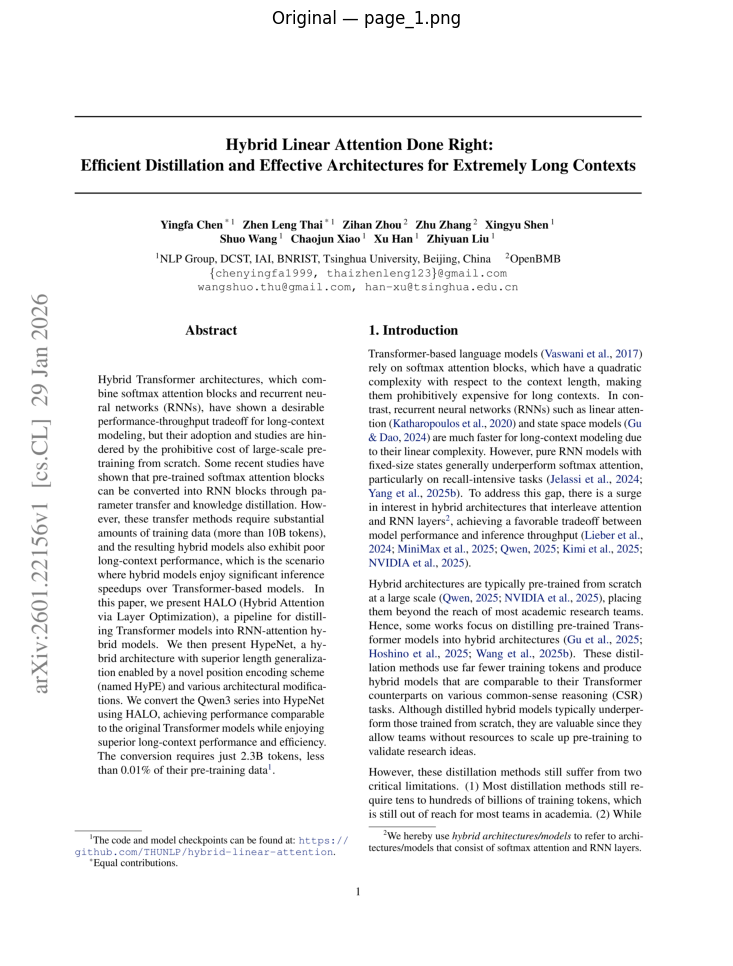

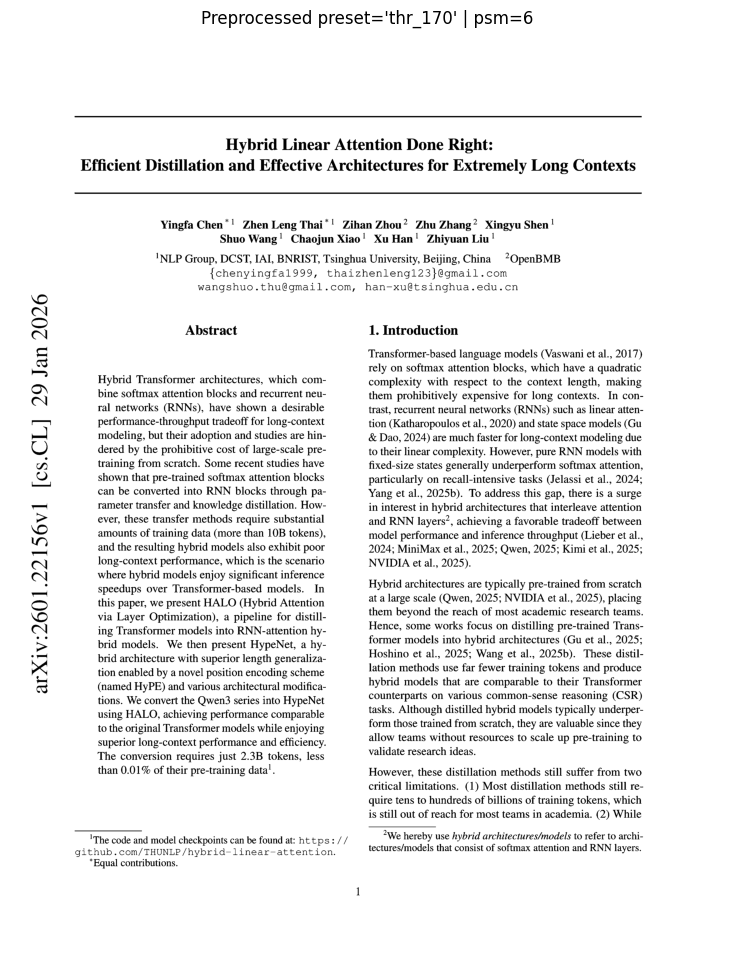

Stats: {'words': 580, 'conf_mean': 91.3408505, 'conf_median': 96.14685850000001, 'conf_p10': 90.42850899999999, 'conf_p90': 96.8723319}

OCR Output (preview):
--------------------

Hybrid Linear Attention Done Right:
Efficient Distillation and Effective Architectures for Extremely Long Contexts
Yingfa Chen“! Zhen Leng Thai”! Zihan Zhou? Zhu Zhang’ Xingyu Shen !
Shuo Wang! Chaojun Xiao! Xu Han! Zhiyuan Liu!
'NLP Group, DCST, IAI, BNRIST, Tsinghua University, Beijing, China ”OpenBMB
{chenyingfal1999, thaizhenleng123}@gmail.com
wangshuo.thu@gmail.com, han-xu@tsinghua.edu.cn
\O
N
< Abstract 1. Introduction
= Transformer-based language models (Vaswani et al., 2017)
S rely on softmax attention blocks, which have a quadratic
Hybrid Transformer architectures, which com- complexity with respect to the context length, making
<a bine softmax attention blocks and recurrent neu- them prohibitively expensive for long contexts. In con-
ral networks (RNNs), have shown a desirable trast, recurrent neur

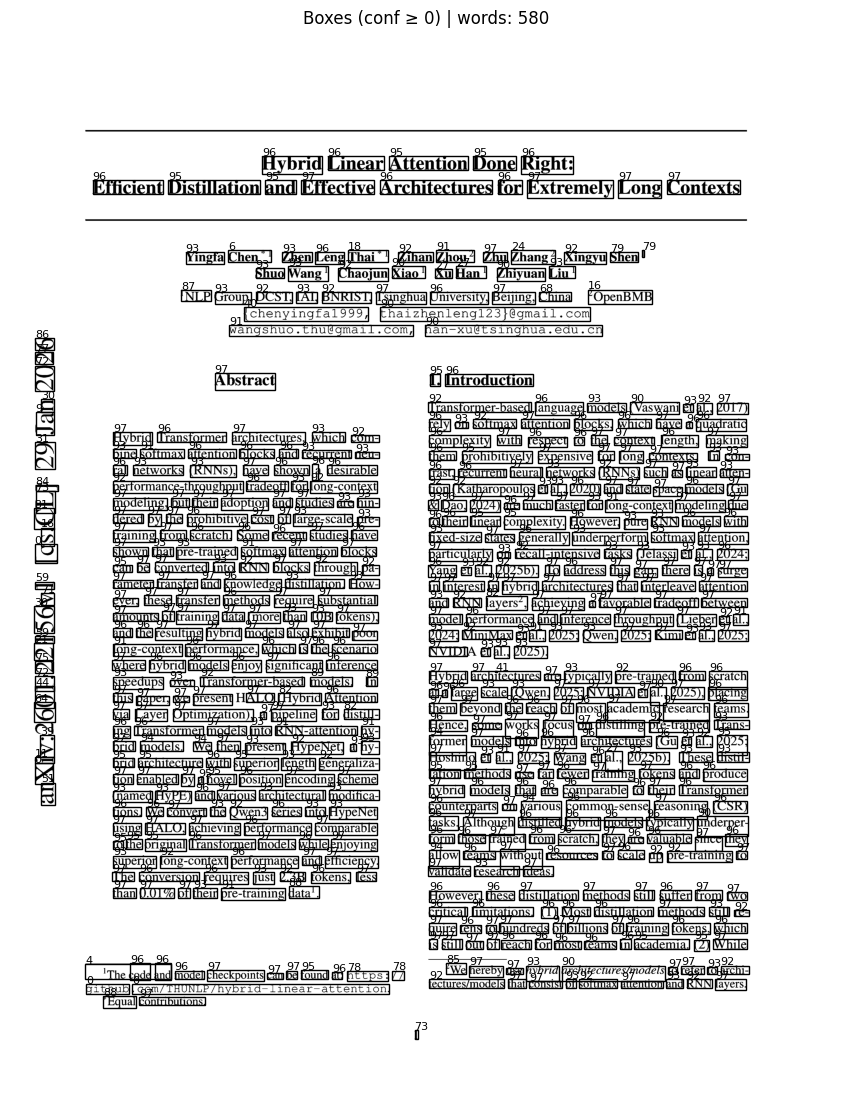

(<PIL.Image.Image image mode=L size=3825x4950>,
      level  page_num  block_num  par_num  line_num  word_num  left   top  \
 4        5         1          1        1         1         1  1156   569   
 5        5         1          1        1         1         2  1458   569   
 6        5         1          1        1         1         3  1739   569   
 7        5         1          1        1         1         4  2125   570   
 8        5         1          1        1         1         5  2348   569   
 ..     ...       ...        ...      ...       ...       ...   ...   ...   
 625      5         1          1        1        46        10  3106  4350   
 626      5         1          1        1        46        11  3238  4349   
 628      5         1          1        1        47         1   428  4428   
 629      5         1          1        1        47         2   594  4430   
 631      5         1          1        1        48         1  1857  4582   
 
      width  height       

In [26]:
evaluate_page(PATH1, preset="thr_170", psm=6)

### Observations
Despite good overall OCR confidence, several qualitative issues are observed:

- **Multi-column layout mixing**
  - Text from the left and right columns is interleaved.
  - Lines from the *Abstract* are followed by lines from the *Introduction*, breaking reading order.

- **Layout noise interpreted as text**
  - Margin elements, separators and decorative lines are detected as characters.
  - Results in isolated letters and symbols with no semantic meaning.

-  **Broken words and hyphenation artifacts**
    - Words split across lines in the original PDF remain fragmented.
    - Affects readability and lexical consistency.

-  **Malformed punctuation and symbols**
    - Superscripts, footnotes and special symbols are incorrectly rendered.
    - Common in author lists, affiliations and references.

-  **Loss of document structure**
   - Section boundaries (e.g. Abstract vs Introduction) are not preserved.
   - Paragraph-level organization is partially flattened.

-  **Risk for downstream LLM usage**
    - Mixed sections and noisy tokens can confuse language models.
    - Additional layout-aware preprocessing or cleaning is required before LLM ingestion.


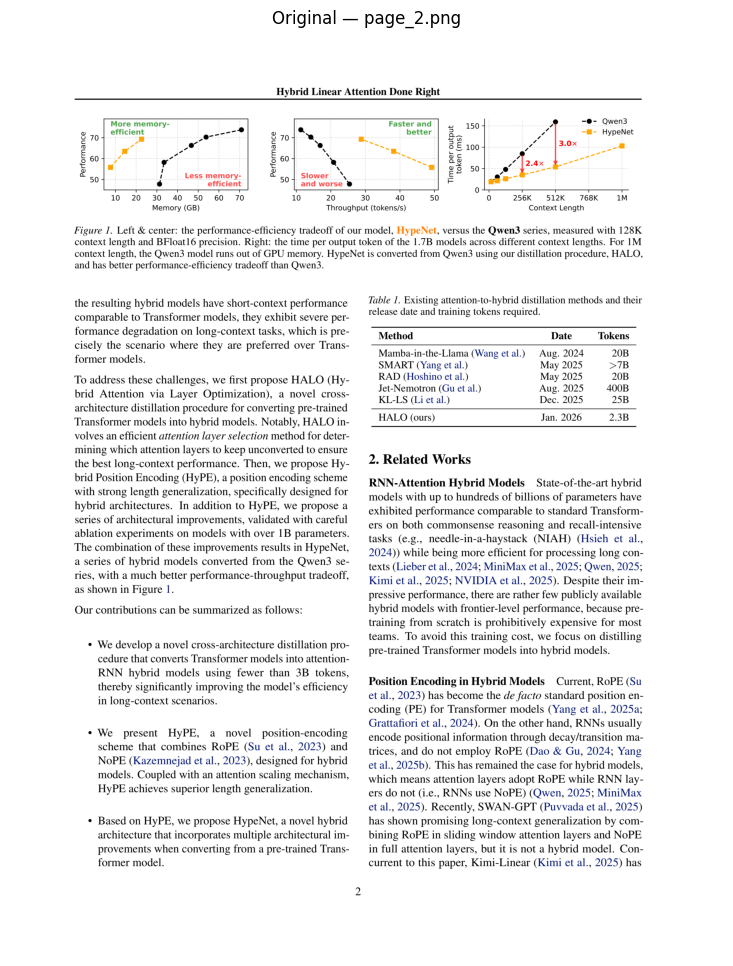

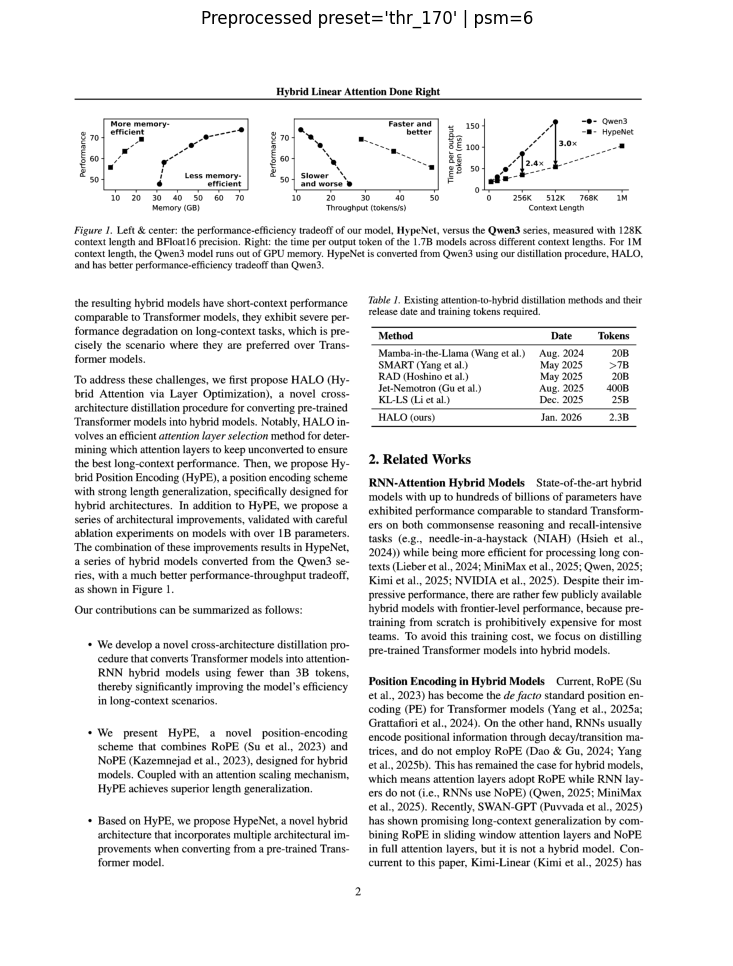

Stats: {'words': 739, 'conf_mean': 82.71566936535861, 'conf_median': 95.097374, 'conf_p10': 33.145214599999996, 'conf_p90': 96.7228618}

OCR Output (preview):
--------------------

Hybrid Linear Attention Done Right
More memory- Fasterand | ,, 4150 y, ~@- Qwen3
wo efficient _---7*® o @ better a v -E- HypeNet
Y 70 Z ® 2707 8 ee Es ’
s a ae ~~ Ng 3 £ 100 a 3.0% _--#
5 604,” °° 5 60 ‘e arn £5 v aa
= |" P E \\ ~m) oS sof et yeti”
10 20 30 40 50 60 70 10 20 30 40 50 0 256K 512K 768K 1M
Memory (GB) Throughput (tokens/s) Context Length
Figure 1. Left & center: the performance-efficiency tradeoff of our model, HypeNet, versus the Qwen3 series, measured with 128K
context length and BFloat16 precision. Right: the time per output token of the 1.7B models across different context lengths. For 1M
context length, the Qwen3 model runs out of GPU memory. HypeNet is converted from Qwen3 using our distillation procedure, HALO,
and has better performance-efficiency tradeoff than Qwen3.
the resulting hybr

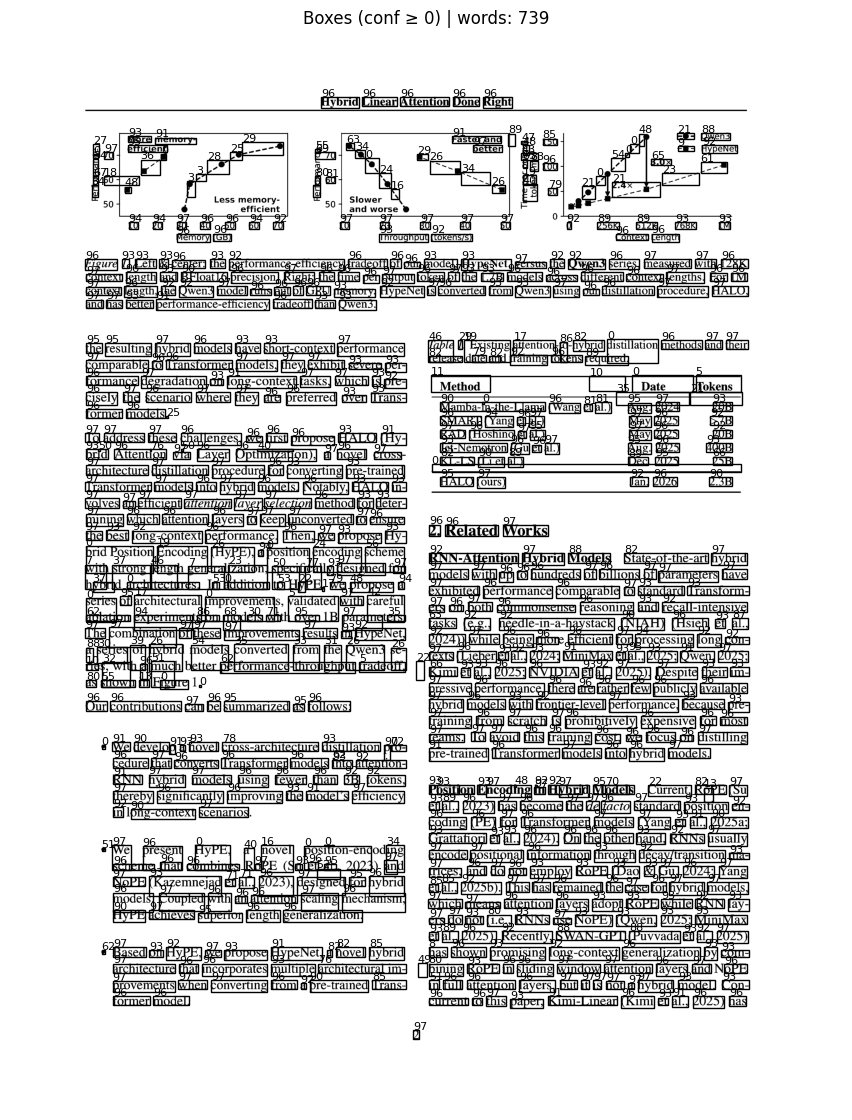

(<PIL.Image.Image image mode=L size=3825x4950>,
      level  page_num  block_num  par_num  line_num  word_num  left   top  \
 4        5         1          1        1         1         1  1427   298   
 5        5         1          1        1         1         2  1615   298   
 6        5         1          1        1         1         3  1791   298   
 7        5         1          1        1         1         4  2032   299   
 8        5         1          1        1         1         5  2172   298   
 ..     ...       ...        ...      ...       ...       ...   ...   ...   
 794      5         1          1        1        57         9  2975  4433   
 795      5         1          1        1        57        10  3040  4426   
 796      5         1          1        1        57        11  3135  4426   
 797      5         1          1        1        57        12  3300  4426   
 799      5         1          1        1        58         1  1851  4582   
 
      width  height       

In [27]:
evaluate_page(PATH2, preset="thr_170", psm=6)

### Observations

When processing pages containing graphs and tables, the following issues are observed:

- **Charts and plots are not semantically interpreted**
  - Only scattered labels or numbers are extracted.
  - Visual relationships (axes, trends, legends) are completely lost.

- **Tables are poorly detected**
  - Rows and columns are not preserved.
  - Table content is flattened into fragmented, unordered text.
  - Numeric values may be merged with unrelated text.

- **High amount of visual noise**
  - Grid lines, borders and separators are misinterpreted as characters.
  - Results in corrupted text that mixes content from figures, tables and surrounding paragraphs.


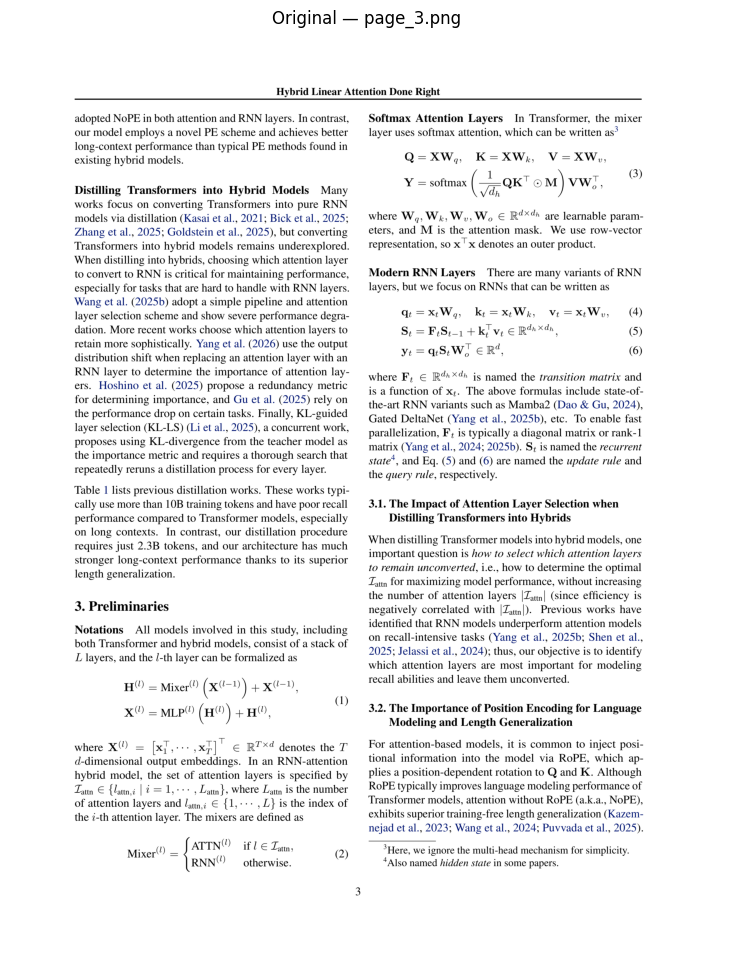

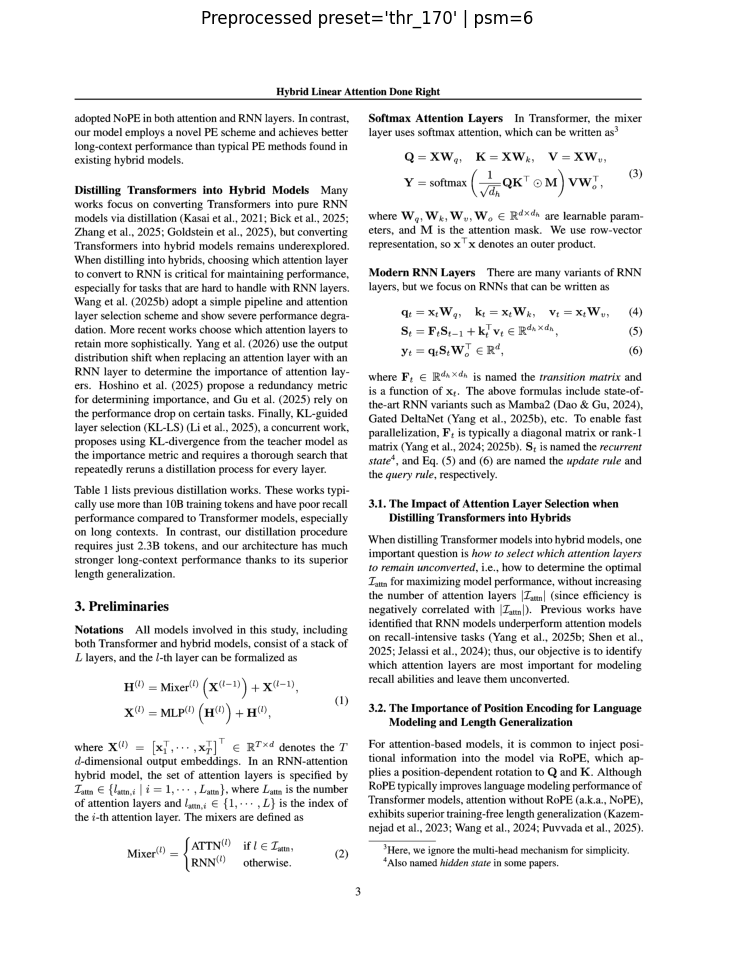

Stats: {'words': 767, 'conf_mean': 84.99906782529335, 'conf_median': 96.033791, 'conf_p10': 43.42148, 'conf_p90': 96.8849336}

OCR Output (preview):
--------------------

Hybrid Linear Attention Done Right
adopted NoPE in both attention and RNN layers. Incontrast, | Softmax Attention Layers In Transformer, the mixer
our model employs a novel PE scheme and achieves better —_ layer uses softmax attention, which can be written as*
long-context performance than typical PE methods found in
existing hybrid models. Q=XW,, K=XW;, V=XW,,
1 (3)
Y = soft —QK'oM)vw}
Distilling Transformers into Hybrid Models Many sommes (. /dy, QK' © ) °°
works focus on converting Transformers into pure RNN
models via distillation (Kasai et al., 2021; Bick et al., 2025; | where W,,W;,W,,W. © R**% are learnable param-
Zhang et al., 2025; Goldstein et al., 2025), but converting eters, and M is the attention mask. We use row-vector
Transformers into hybrid models remains underexplored. _tepresentation, so x'x denotes

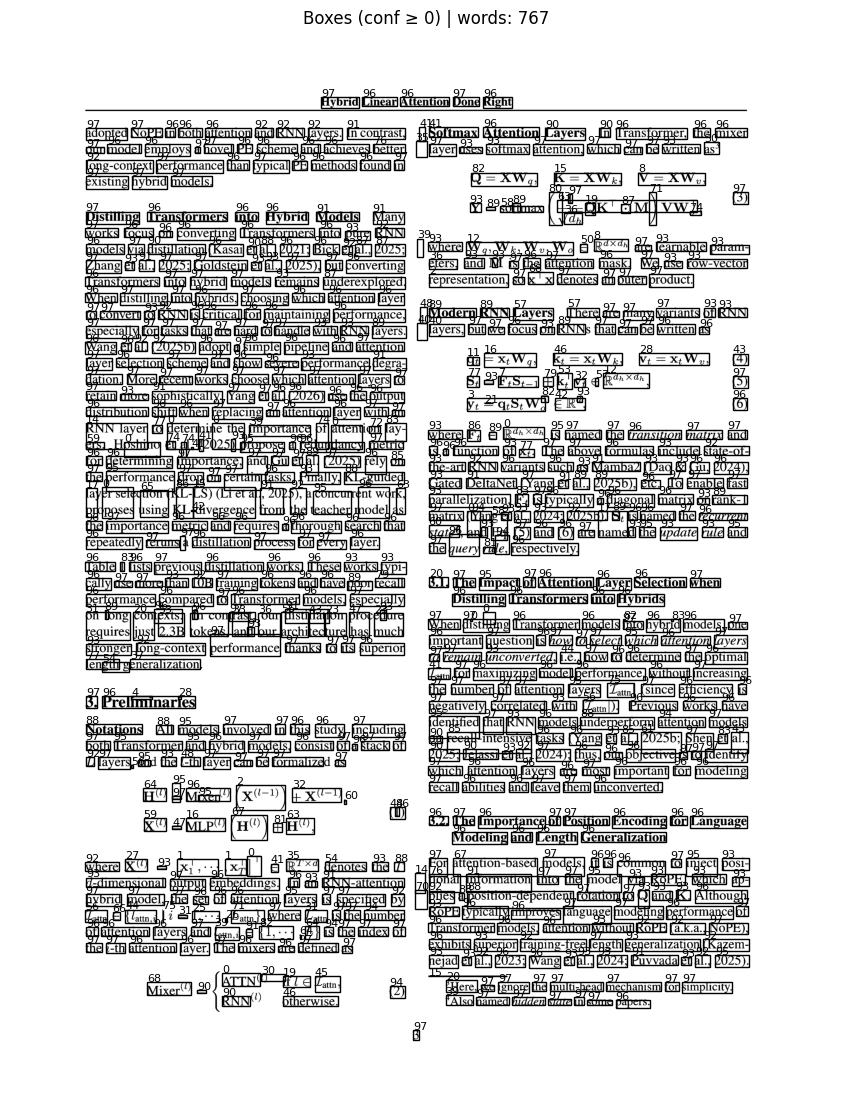

(<PIL.Image.Image image mode=L size=3825x4950>,
      level  page_num  block_num  par_num  line_num  word_num  left   top  \
 4        5         1          1        1         1         1  1427   298   
 5        5         1          1        1         1         2  1615   298   
 6        5         1          1        1         1         3  1791   298   
 7        5         1          1        1         1         4  2032   299   
 8        5         1          1        1         1         5  2172   298   
 ..     ...       ...        ...      ...       ...       ...   ...   ...   
 822      5         1          1        1        57         6  2471  4438   
 823      5         1          1        1        57         7  2591  4430   
 824      5         1          1        1        57         8  2650  4443   
 825      5         1          1        1        57         9  2781  4443   
 827      5         1          1        1        58         1  1852  4582   
 
      width  height       

In [31]:
evaluate_page(PATH3, preset="thr_170", psm=6)

### Observations 

When processing pages with mathematical expressions and formulas, OCR quality degrades noticeably:

- **Mathematical formulas are incorrectly parsed**
  - Symbols, subscripts and superscripts are misinterpreted or lost.
  - Expressions are flattened into invalid text (e.g. matrices, fractions, attention equations).

- **Severe symbol corruption**
  - Mathematical operators (e.g. ×, ⊤, √, subscripts) are replaced by random characters.
  - Variable names and notation become inconsistent or unreadable.

- **Loss of semantic meaning**
  - Extracted formulas cannot be reliably reconstructed or interpreted.
  - The resulting text is unsuitable for downstream LLMs or mathematical reasoning tasks.
